In [42]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from statannotations.Annotator import Annotator
from input_str import pair_sample

This script is adapted from https://github.com/acg-team/STRs-in-CRC/tree/main/notebooks/somatic_mutations

In [44]:
cancer_type = "UCEC"
df_str = pair_sample(cancer_type)

In [45]:
mask = ~((df_str.allele_a_t == df_str.allele_b_t) &   # homozygous in tumor
        (df_str.allele_a_t != df_str.allele_a_n) &  # not equal healthy allele a
        (df_str.allele_a_t != df_str.allele_b_n))   # ...or healthy allele b
df_str = df_str[mask]

In [47]:
def calc_len_differences(a: np.array, b: np.array, aprime: np.array, bprime: np.array):
    """
    Given four arrays of STR allele lengths (two from healthy samples, two from patient-matched tumor samples),
    calculate the smallest unit number difference that would transform  'a' and 'b' into 'a_prime' and 'b_prime'.
    To do this, calculate the difference for two scenarios:
        a -> a_prime & b -> b_prime 
        OR 
        a -> b_prime & b -> a_prime
    The scenario yielding the smallest unit difference between the alleles of the healthy sample and the tumor
    sample is assumed to be the most likely.
    """
    # make matrix to store results
    # res_m[0]: alle_a_differences, res_m[1]: allele_b_differences, res_m[2]: sum of absolute differences
    res_m = np.array(
        [
            np.zeros(len(a)),
            np.zeros(len(a)),
            np.zeros(len(a)),
        ]    
    )
    # Case where allele a healthy -> allele a tumor
    a_to_a = np.array([aprime-a, bprime-b])
    a_to_a_diff = np.abs(a_to_a).sum(axis=0)
    # Case where allele a healthy -> allele b tumor
    a_to_b = np.array([bprime-a, aprime-b])
    a_to_b_diff = np.abs(a_to_b).sum(axis=0)
    
    # Make boolian array for indexing, smallest difference between healthy and 
    # tumor is assumed most likely scenario
    comp = (a_to_a_diff >= a_to_b_diff)
    
    res_m[0:2, ~comp] = a_to_a[:, ~comp]
    res_m[0:2, comp] = a_to_b[:, comp]
    
    res_m[2, ~comp] = a_to_a_diff[~comp]
    res_m[2, comp] = a_to_b_diff[comp]
    
    return res_m.T

In [48]:
res = calc_len_differences(
    df_str.allele_a_n.to_numpy(),
    df_str.allele_b_n.to_numpy(),
    df_str.allele_a_t.to_numpy(),
    df_str.allele_b_t.to_numpy(),   
)
df_str[['allele_a_diff', 'allele_b_diff', 'patient_len_diff']] = pd.DataFrame(res, 
    index = df_str.index).astype(np.int32)

In [12]:
def mutation_calculate(df_str):
    df_indel = df_str[["tmp_id", "patient", "allele_a_diff", "allele_b_diff", "patient_len_diff", "msi_status"]].dropna(subset = ["msi_status"])
    df_somatic_deletions = (df_indel
                                .assign(
                                    allele_a_diff = lambda x: np.minimum(0, x.allele_a_diff),
                                    allele_b_diff = lambda x: np.minimum(0, x.allele_b_diff),
                                    patient_len_diff = lambda x: abs(x.allele_a_diff + x.allele_b_diff),
                                    mut_type = pd.Categorical(["deletion"] * len(df_indel))
                                ))
    df_barplot_deletions = (
        df_somatic_deletions
            .groupby("patient")
            .size()
            .reset_index()
    )
    df_barplot_deletions.columns = ["patient", "total_count"]

    df_barplot_deletions = df_barplot_deletions.merge(
        df_somatic_deletions[df_somatic_deletions["patient_len_diff"] > 0].groupby("patient").size().reset_index(),
        on="patient", how="left"
    )

    df_barplot_deletions.columns = ["patient", "total_count", "variable_count"]
    df_barplot_deletions["perc_loci_var"] = df_barplot_deletions["variable_count"] / df_barplot_deletions["total_count"] * 100
    df_barplot_deletions = df_barplot_deletions.merge(df_indel[["patient", "msi_status"]], on="patient", how="left")
    df_barplot_deletions = (
        df_barplot_deletions
            .drop_duplicates()
            .sort_values(by="perc_loci_var")
            .reset_index(drop=True)
            .assign(patient = lambda x: x.patient.apply(str))
    )
    df_somatic_insertions = (df_indel
                                .assign(
                                    allele_a_diff = lambda x: np.maximum(0, x.allele_a_diff),
                                    allele_b_diff = lambda x: np.maximum(0, x.allele_b_diff),
                                    patient_len_diff = lambda x: abs(x.allele_a_diff + x.allele_b_diff),
                                    mut_type = pd.Categorical(["insertion"] * len(df_indel))
                                ))
    df_barplot_insertions = (
        df_somatic_insertions
            .groupby("patient")
            .size()
            .reset_index()
    )
    df_barplot_insertions.columns = ["patient", "total_count"]

    df_barplot_insertions = df_barplot_insertions.merge(
        df_somatic_insertions[df_somatic_insertions["patient_len_diff"] > 0].groupby("patient").size().reset_index(),
        on="patient", how="left"
    )

    df_barplot_insertions.columns = ["patient", "total_count", "variable_count"]
    df_barplot_insertions["perc_loci_var"] = df_barplot_insertions["variable_count"] / df_barplot_insertions["total_count"] * 100
    # df_barplot_insertions = df_barplot_insertions.merge(df_clinical, on="patient", how="left")
    df_barplot_insertions = df_barplot_insertions.merge(df_indel[["patient", "msi_status"]], on="patient", how="left")
    df_barplot_insertions = (
        df_barplot_insertions
            .drop_duplicates()
            .sort_values(by="perc_loci_var")
            .reset_index(drop=True)
            .assign(patient = lambda x: x.patient.apply(str))
    )

    target_cols = []
    df_somatic_indels = pd.concat([
        df_barplot_deletions.assign(mut_type = pd.Categorical(["deletion"] * len(df_barplot_deletions), categories=["deletion", "insertion"])),
        df_barplot_insertions.assign(mut_type = pd.Categorical(["insertion"] * len(df_barplot_insertions), categories=["deletion", "insertion"]))
    ]).reset_index(drop=True)
    
    return df_somatic_indels

In [34]:
msi_info = pd.read_csv("../clinical/" + cancer_type + "_msi.csv")
msi_info.loc[msi_info["msi_status"] == "msi-l", "msi_status"] = "mss"
df_str = df_str.merge(msi_info, on = "patient", how="left")
df_somatic_indels = mutation_calculate(df_str)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

insertion_mss vs. insertion_msi-h: Mann-Whitney-Wilcoxon test two-sided, P_val:3.188e-07 U_stat=1.598e+04
deletion_mss vs. deletion_msi-h: Mann-Whitney-Wilcoxon test two-sided, P_val:1.072e-61 U_stat=7.530e+02


Text(0.5, 1.0, 'UCEC')

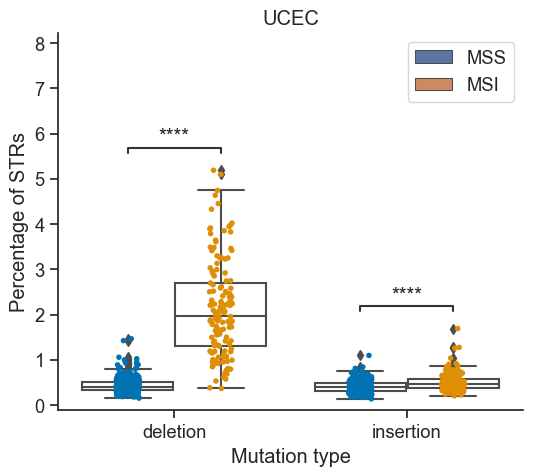

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5), dpi = 100)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.2)

sns.boxplot(ax = axes,
    data = df_somatic_indels,
    x="mut_type",
    y="perc_loci_var",
    hue="msi_status",
    boxprops={'facecolor':'None'}
)
annot = Annotator(ax = axes, pairs = [(("deletion", "mss"), ("deletion", "msi-h")), 
                                         (("insertion", "mss"), ("insertion", "msi-h"))], hue = "msi_status",
                  data = df_somatic_indels, x = "mut_type", y = "perc_loci_var")
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate()

handles = axes.legend_.legendHandles
labels = [text.get_text() for text in axes.legend_.texts]

sns.stripplot(ax = axes,
    data = df_somatic_indels,
    x="mut_type",
    y="perc_loci_var",
    hue="msi_status",
    palette="colorblind",
    dodge=True,
    color="black",
    s=4
)

axes.set(
    xlabel="Mutation type",
    ylabel="Percentage of STRs",    
    ylim=(None, axes.get_ylim()[1] + 2),
)

legend_handles, _ = axes.get_legend_handles_labels()
axes.legend(legend_handles, ["MSS", "MSI"], 
           bbox_to_anchor=(1,1))
axes.set_title(cancer_type)